# Import

In [1]:

import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
import scipy.io as sio

sys.path.append(os.path.abspath("../src"))

from utils.mpiifacegaze_dataset import *
import torch
from torch.utils.data import DataLoader
from tracker import GazeModel
from utils.mpiifacegaze_dataset import *

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/pather/.local/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
print(f"{torch.cuda.get_device_name(torch.cuda.current_device())}")

Quadro P1000


# Preprocessing - Stats

In [3]:
dataset = MPIIFaceGazeDataset(root_dir='../dataset/MPIIFaceGaze/')
df = dataset.to_dataframe(normalize=False)

In [4]:
print(df.head())

  subject                                    img_path  gaze_x  gaze_y
0     p00  ../dataset/MPIIFaceGaze/p00/day01/0005.jpg   476.0   758.0
1     p00  ../dataset/MPIIFaceGaze/p00/day01/0030.jpg  1078.0   693.0
2     p00  ../dataset/MPIIFaceGaze/p00/day01/0031.jpg   126.0   598.0
3     p00  ../dataset/MPIIFaceGaze/p00/day01/0038.jpg   211.0    69.0
4     p00  ../dataset/MPIIFaceGaze/p00/day01/0063.jpg   878.0   752.0


In [5]:
len(dataset)

37667

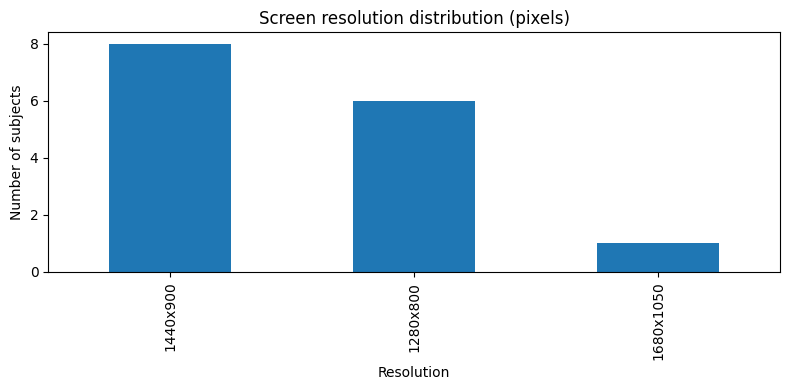

In [6]:
dataset.plot_screen_size_histogram()

In [7]:
df = dataset.to_dataframe(normalize=True)

In [8]:
df

,subject,img_path,gaze_x,gaze_y
0,p00,../dataset/MPIIFaceGaze/p00/day01/0005.jpg,0.371875,0.947500
1,p00,../dataset/MPIIFaceGaze/p00/day01/0030.jpg,0.842187,0.866250
2,p00,../dataset/MPIIFaceGaze/p00/day01/0031.jpg,0.098437,0.747500
3,p00,../dataset/MPIIFaceGaze/p00/day01/0038.jpg,0.164844,0.086250
4,p00,../dataset/MPIIFaceGaze/p00/day01/0063.jpg,0.685937,0.940000
...,...,...,...,...
37662,p14,../dataset/MPIIFaceGaze/p14/day07/0196.jpg,0.506944,0.153333
37663,p14,../dataset/MPIIFaceGaze/p14/day07/0197.jpg,0.668750,0.892222
37664,p14,../dataset/MPIIFaceGaze/p14/day07/0198.jpg,0.929861,0.890000
37665,p14,../dataset/MPIIFaceGaze/p14/day07/0199.jpg,0.945833,0.102222


In [9]:
generate_means(df)

I0000 00:00:1752069599.707201   47530 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752069599.709923   47604 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Computing mean tensors:   0%|          | 0/1178 [00:00<?, ?it/s]W0000 00:00:1752069599.714554   47598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752069599.734988   47588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752069599.737893   47597 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Computing mean tensors:   2%|▏

KeyboardInterrupt: 

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_dataset = FaceGazeDataset(train_df)
test_dataset = FaceGazeDataset(test_df)


I0000 00:00:1751927613.417735  185041 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1751927613.431500  186748 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4090)
W0000 00:00:1751927613.439868  186721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1751927613.440623  185041 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1751927613.449547  186735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1751927613.453064  186782 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4090)


W0000 00:00:1751927613.456255  186754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751927613.466553  186773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
model = GazeModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20

In [13]:
import cv2
import mediapipe as mp
from utils.utils import *

In [14]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.3,refine_landmarks=True, max_num_faces=1)

I0000 00:00:1752069634.576916   47530 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752069634.578975   47665 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)


W0000 00:00:1752069634.583791   47654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752069634.601486   47653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [15]:
df.iloc[31]["img_path"]

'../dataset/MPIIFaceGaze/p00/day01/0347.jpg'

In [16]:
img = cv2.imread(df.iloc[31]["img_path"])

In [17]:

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_mp = face_mesh.process(img_rgb)

In [21]:
h, w, _ = img.shape
LEFT_EYE = [33, 133, 159, 160, 158, 144]
RIGHT_EYE = [362, 263, 386, 387, 385, 373]


In [19]:
if img_mp.multi_face_landmarks:
    for face_landmarks in img_mp.multi_face_landmarks:
        landmarks = [(int(pt.x * w), int(pt.y * h)) for pt in face_landmarks.landmark]
        face_bbox = get_bounding_box(FACE_OVAL, landmarks, w, h)
        left_eye_bbox = get_bounding_box(LEFT_EYE, landmarks,w,h)
        right_eye_bbox = get_bounding_box(RIGHT_EYE,landmarks,w,h)
        print("face:",face_bbox)
        print("left_eye :", left_eye_bbox)
        print("right_eye :", right_eye_bbox)

face: (615, 407, 864, 712)
left_eye : (650, 498, 700, 516)
right_eye : (761, 482, 812, 499)


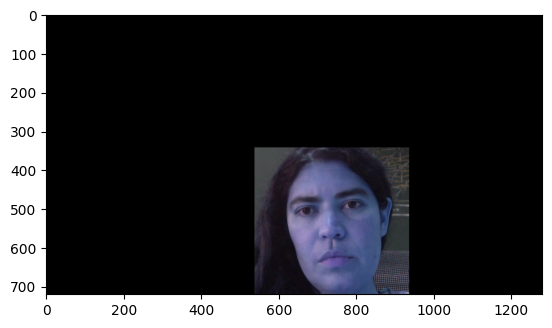

In [20]:
plt.imshow(img)

In [55]:
face_bbox

(540, 272, 812, 617)

In [54]:
face_bbox[1],face_bbox[3]

(272, 617)

In [56]:
face_roi = preprocess_roi(img[face_bbox[1]:face_bbox[3], face_bbox[0]:face_bbox[2]])


In [61]:
left_eye_roi = preprocess_roi(img[left_eye_bbox[1]:left_eye_bbox[3], left_eye_bbox[0]:left_eye_bbox[2]])
right_eye_roi = preprocess_roi(img[right_eye_bbox[1]:right_eye_bbox[3], right_eye_bbox[0]:right_eye_bbox[2]])